In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### formatting
column 1 is yyyy_dd_hh
row 1 is generator # (s/a in the generator input file)

#### to do
1. sum each row to get the annual total per generator
2. sum the rows by state in which the generator is located
3. import egrids data
4. subtract the model output by state from the state annual emissions from egrid

#### approach
1. see if the data is linearly correlated or what the relationship is between the model/generation
2. see if a specific type of power plant is off and others are correct
3. see if a specific region of power plant is off

# Generation

## Pre-processing of data into the final gmodel_egrid dataset for both nonuc and normal scenario

In [3]:
###### import the datasets #######

egrid_ds = xr.open_dataset('../optimization_model/outputs/egrid_ds.nc')
gen_nonuc_ds = xr.open_dataset('../optimization_model/outputs/gen_nonuc_ds.nc')
gen_normal_ds = xr.open_dataset('../optimization_model/outputs/gen_normal_ds.nc')
oris_nonuc_ds = xr.open_dataset('../optimization_model/outputs/oris_nonuc_ds.nc')
oris_normal_ds = xr.open_dataset('../optimization_model/outputs/oris_normal_ds.nc')

In [4]:
###### setup for our datasets #######

###create dicts of our datasets/names
gen_names_dict = {'normal':gen_normal_ds,'nonuc':gen_nonuc_ds}
oris_names_dict = {'normal':oris_normal_ds,'nonuc':oris_nonuc_ds}
models = ['normal','nonuc']

### group egrid by ORIS code, sum, and drop the capacity factor (because it wouldn't be the sum)
egrid = egrid_ds.groupby('ORISCode').sum().drop('egrid_capafactor')

KeyboardInterrupt: 

In [4]:
####### concatenate our different dataset components together #######

### define dicts for output
capacity = {}
fueltype = {}
regionname = {}
gmodel_oris = {}
gmodel_egrid = {}

for name in models:
    ###set up inputs
    #create a capacity, fueltype, and regionname dict grouped by ORISCode
    capacity[name] = oris_names_dict[name].groupby('ORISCode').sum()['Capacity']
    fueltype[name]= oris_names_dict[name].to_dataframe().groupby('ORISCode').first()['FuelType']
    regionname[name]= oris_names_dict[name].to_dataframe().groupby('ORISCode').first()['RegionName']
    #group ORIS dicts by ORIS code and take the mean of everything but capacity
    oris_names_dict[name] = oris_names_dict[name].groupby('ORISCode').mean().drop('Capacity')
    #rename our generation variable
    gen_names_dict[name] = gen_names_dict[name].rename({'__xarray_dataarray_variable__':'modelgeneration'})

    ###concatenate the generation and ORIS files
    gmodel_oris[name] = xr.merge([gen_names_dict[name], oris_names_dict[name]])
    #add in the capacity
    gmodel_oris[name]['Capacity'] = capacity[name]
    #create a column for capacity factors
    gmodel_oris[name]['model_capafactor'] = 100 * gmodel_oris[name]['modelgeneration'] / (gmodel_oris[name]['Capacity'] * 8760) # % generation for each year's total capacity
    
    ###concatenate our model/oris and egrid emissions dataframes into one, grouped by ORIS code
    gmodel_egrid[name] = xr.merge([gmodel_oris[name],egrid])
    #turn all zeroes (just in the modelgeneration) to NAN
    gmodel_egrid[name].where('modelgeneration' == 0)['modelgeneration'] = np.nan
    #rename the egrid data column for ease
    gmodel_egrid[name] = gmodel_egrid[name].rename({'Generator annual net generation (MWh)':'egridgeneration'})
    #add in fueltype
    gmodel_egrid[name]['fueltype'] = fueltype[name]
    gmodel_egrid[name] = gmodel_egrid[name].set_coords('fueltype')
    #add in region name
    gmodel_egrid[name]['regionname'] = regionname[name]
    gmodel_egrid[name] = gmodel_egrid[name].set_coords('regionname')
    
    


/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
####### fix datetime and add dec 31st at the 23rd hour ######

###create a dict for dec 31st 23rd hour (just copy the dec 31 22nd hour data over)
ds_dec23 = {}
for name in models:
    ds_dec23[name] = gmodel_egrid[name].isel(date = [-1])
    #change date to datetime for the 23rd hour
    ds_dec23[name]['date'] = [datetime.datetime(2017,12,31,23,0)]

###change all dates to datetime
#make a list of dates for the year
base = datetime.datetime(2017, 1, 1) #base date
date_list = [base + datetime.timedelta(hours=x) for x in range(8759)] #loop through all hours but the final one (we will add it in above)
date_list
for name in models:
    gmodel_egrid[name]['date'] = date_list
    gmodel_egrid[name] = xr.merge([gmodel_egrid[name],ds_dec23[name]])

Note:

To convert our generation in MWh to get the emissions in kg/sec, we use the following (and making sure our emissions rates are in kg/sec)

$MWH/3600sec -> (MW = J/sec) * kg/J -> kg/sec$


In [6]:
###### NOx and SO2 emissions to gmodel_egrid dataset ######

no_mult = 0.8544304 # NO/NOx as estimated from NEI2011 inventory
no2_mult = 1 - 0.8544304 # NO2/NOx as estimated from NEI2011 inventory
### process our NO, NO2, SO2 emissions
for name in models:
    gmodel_egrid[name]['NO']  = no_mult * gmodel_egrid[name]['modelgeneration']/3600 * gmodel_egrid[name]['PLNOXRTA']
    gmodel_egrid[name]['NO2']  = no2_mult * gmodel_egrid[name]['modelgeneration']/3600 * gmodel_egrid[name]['PLNOXRTA']
    gmodel_egrid[name]['SO2']  =  gmodel_egrid[name]['modelgeneration']/3600 * gmodel_egrid[name]['PLSO2RTA']
    
##### annual generation in original dataset ######
    gmodel_egrid[name]['annual_modelgeneration'] = gmodel_egrid[name]['modelgeneration'].groupby('ORISCode').sum(dim = 'date')

In [7]:
####### create new datasets for region and fuel type grouped data, add annual generation to normal ds ######
###dicts for datasets
fueltype_grouped_ds = {}
regionname_grouped_ds = {}

###list of pollutants
pollutants = ['NO','NO2','SO2']


In [8]:
for name in models:
    
###new datasets    
    #annual generation by fuel type
    fueltype_grouped_ds[name] = gmodel_egrid[name].groupby('fueltype').sum(dim = 'ORISCode')
    fueltype_grouped_ds[name].drop(['model_capafactor','PLCH4RTA','PLCO2RTA','PLNOXRTA','PLSO2RTA','PLN2ORTA'])
    
    #annual generation by region
    regionname_grouped_ds[name] = gmodel_egrid[name].groupby('regionname').sum(dim = 'ORISCode')
    regionname_grouped_ds[name].drop(['model_capafactor','PLCH4RTA','PLCO2RTA','PLNOXRTA','PLSO2RTA','PLN2ORTA'])

    #add annual emissions of each pollutant
    for pollutant in pollutants:
        regionname_grouped_ds[name][f'annual_{pollutant}'] = regionname_grouped_ds[name][f'{pollutant}'].sum(dim = 'date')
        fueltype_grouped_ds[name][f'annual_{pollutant}'] = fueltype_grouped_ds[name][f'{pollutant}'].sum(dim = 'date')
#add ratio of difference in emissions normal-nonuc/ difference in generation normal-nonuc to the nonuc dataset
for pollutant in pollutants:
    fueltype_grouped_ds['nonuc'][f'normal-nonuc_{pollutant}-gen_ratio'] = (fueltype_grouped_ds['normal'][f'annual_{pollutant}']-fueltype_grouped_ds['nonuc'][f'annual_{pollutant}'])/(fueltype_grouped_ds['normal']['annual_modelgeneration']-fueltype_grouped_ds['nonuc']['annual_modelgeneration'])
    regionname_grouped_ds['nonuc'][f'normal-nonuc_{pollutant}-gen_ratio'] = (regionname_grouped_ds['normal'][f'annual_{pollutant}']-regionname_grouped_ds['nonuc'][f'annual_{pollutant}'])/(regionname_grouped_ds['normal']['annual_modelgeneration']-regionname_grouped_ds['nonuc']['annual_modelgeneration'])

In [9]:
gmodel_egrid

{'normal': <xarray.Dataset>
 Dimensions:                            (ORISCode: 9749, date: 8760)
 Coordinates:
   * date                               (date) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
   * ORISCode                           (ORISCode) int64 2 3 4 ... 61449 70454
     fueltype                           (ORISCode) object 'Hydro' 'Coal' ... nan
     regionname                         (ORISCode) object 'S_SOU' 'S_SOU' ... nan
 Data variables:
     modelgeneration                    (ORISCode, date) float64 10.98 ... nan
     PLCO2RTA                           (ORISCode) float64 0.0 585.0 ... nan nan
     PLNOXRTA                           (ORISCode) float64 0.0 0.2917 ... nan nan
     PLSO2RTA                           (ORISCode) float64 0.0 0.3851 ... nan nan
     PLN2ORTA                           (ORISCode) float64 0.0 0.005897 ... nan
     PLCH4RTA                           (ORISCode) float64 0.0 0.04173 ... nan
     Capacity                           (ORISCode)

### Final datsets are: gmodel_egrid, fueltype_grouped_ds, regionname_grouped_ds

# Plots

In [15]:
###set color for each type
nonuc_color = 'C1'
normal_color = 'C0'
egrid_color = 'C7'


## Annual Generation by ORIS Code

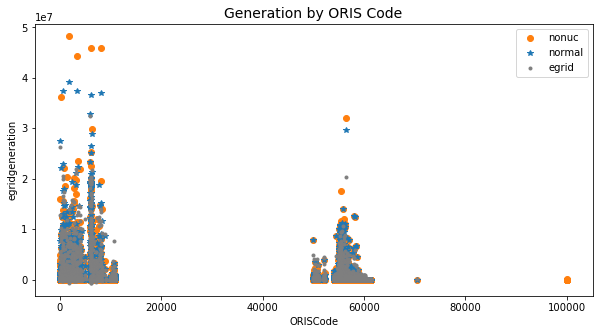

In [10]:
### look at the total generation by ORIS code for each of our scenarios
fig, ax = plt.subplots(figsize = [10,5])
gmodel_egrid['nonuc']['annual_modelgeneration'].plot(color = nonuc_color, label = 'nonuc',marker = 'o',linestyle = "")
gmodel_egrid['normal']['annual_modelgeneration'].plot(color = normal_color, label = 'normal',marker = '*',linestyle = "")
gmodel_egrid['normal']['egridgeneration'].plot(color = egrid_color, label = 'egrid',marker = '.',linestyle = "")
plt.legend()
plt.title('Generation by ORIS Code', fontsize = 14);

## Generator use in the no-nuclear scenario

In [11]:
###determine which regions are using a generator and when
#get list of unique region names and what generators are in which location
reg = np.unique(oris_nonuc_ds['RegionName'])
generator_oris_number = np.arange(100000,100000+len(reg))
#make a dict of region names and their associated oris number
generator_oris_dict = {generator_oris_number[idx]:f'{r}' for idx,r in enumerate(reg)} 


In [65]:
#make a column for generator generation in dataset
gmodel_egrid['nonuc']['generator_generation'] = gmodel_egrid['nonuc']['modelgeneration'].copy()
gmodel_egrid['nonuc']['generator_generation'] = gmodel_egrid['nonuc']['generator_generation'].where(gmodel_egrid['nonuc']['fueltype'] == 'generator')
gmodel_egrid['nonuc']['generator_generation'] = gmodel_egrid['nonuc']['generator_generation'].where(gmodel_egrid['nonuc']['generator_generation'] != 0)

#make a column for our sum of generator generation to find which ORISCodes have generators turned on
gmodel_egrid['nonuc']['generator_generation_sum'] = gmodel_egrid['nonuc']['generator_generation'].sum(dim='date')
ORIS_using_gen = gmodel_egrid['nonuc']['generator_generation_sum'].isel(ORISCode = (gmodel_egrid['nonuc']['generator_generation_sum'] > 0))['ORISCode']

#find the region in which the generator is located
reg_using_gen = generator_oris_dict[ORIS_using_gen.values.item()]
print('Regions using generators are ' + str(reg_using_gen))

for key, value in generator_oris_dict.items(): 
    if reg_using_gen == value: 
        print('Region generator Oris Code is ' + str(key))

#find the times this region is using the generator
times_using_gen = gmodel_egrid['nonuc']['generator_generation'].sel(ORISCode = 100002).isel(date = (gmodel_egrid['nonuc']['generator_generation'].sel(ORISCode = ORIS_using_gen.values.item()) > 0))['date'].values
daily_gen_use = gmodel_egrid['nonuc']['generator_generation'].sel(ORISCode = 100002).isel(date = (gmodel_egrid['nonuc']['generator_generation'].sel(ORISCode = ORIS_using_gen.values.item()) > 0)).values
print('\nTimes generator is used and amounts used are \n' + str(times_using_gen) + '\n' + str(daily_gen_use))

#print the total generation used
print('\nAnnual total generation produced by generators \n' + str(gmodel_egrid['nonuc']['generator_generation_sum'].sum().values))

#make a dataframe with our generator information
generator_df = pd.DataFrame(data = daily_gen_use, index = times_using_gen, columns = ['Generation'])
generator_df = generator_df.rename_axis('Time')

Regions using generators are ERC_REST
Region generator Oris Code is 100002

Times generator is used and amounts used are 
['2017-07-31T13:00:00.000000000' '2017-07-31T14:00:00.000000000'
 '2017-07-31T15:00:00.000000000' '2017-08-01T13:00:00.000000000'
 '2017-08-01T14:00:00.000000000' '2017-08-01T15:00:00.000000000'
 '2017-08-02T12:00:00.000000000' '2017-08-02T13:00:00.000000000'
 '2017-08-02T14:00:00.000000000' '2017-08-02T15:00:00.000000000'
 '2017-08-02T16:00:00.000000000' '2017-08-08T13:00:00.000000000'
 '2017-08-08T14:00:00.000000000' '2017-08-08T15:00:00.000000000'
 '2017-08-17T13:00:00.000000000' '2017-08-17T14:00:00.000000000'
 '2017-08-17T15:00:00.000000000' '2017-08-18T13:00:00.000000000'
 '2017-08-18T14:00:00.000000000' '2017-08-22T14:00:00.000000000']
[ 378.8678985   960.3952985   726.65563149  696.0900261  1021.9402261
  491.53275909 1072.4838089  2261.9974985  2720.4610985  2229.53083149
  637.63643149 1353.0604985  1970.5276985  1552.57183149  804.4774449
 1305.4174449   

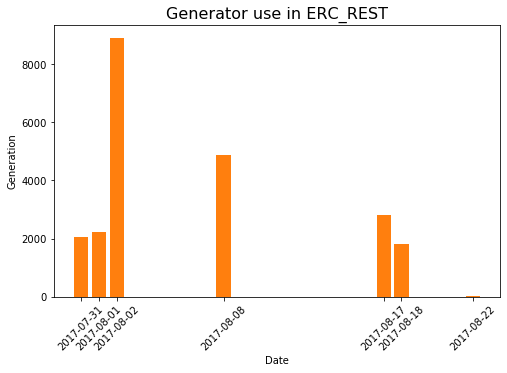

In [71]:
fig,ax = plt.subplots(figsize = [8,5])
plt.bar(generator_df.groupby(generator_df.index.date).sum().index, generator_df.groupby(generator_df.index.date).sum()['Generation'], color = nonuc_color)
plt.xlabel('Date')
plt.ylabel('Generation')
plt.xticks(generator_df.groupby(generator_df.index.date).sum().index, rotation = 45)
plt.title(f'Generator use in {reg_using_gen}', fontsize = 16);

## Nuclear use in our data

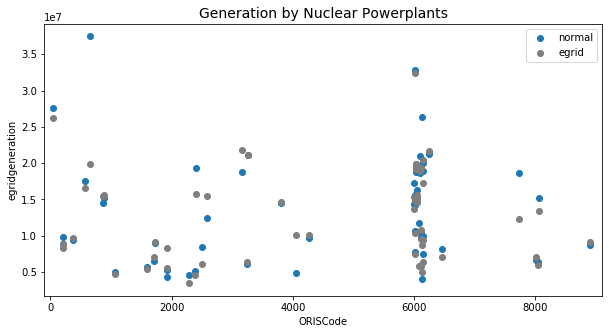

In [72]:
### look at teh total generation by ORIS code for each of our scenarios
fig, ax = plt.subplots(figsize = [10,5])
gmodel_egrid['normal'].sel(ORISCode = (gmodel_egrid['normal']['fueltype'] == 'Nuclear'))['annual_modelgeneration'].plot(marker = 'o',color = normal_color, label = 'normal',linestyle="")
gmodel_egrid['normal'].sel(ORISCode = (gmodel_egrid['normal']['fueltype'] == 'Nuclear'))['egridgeneration'].plot(marker = 'o',color = egrid_color, label = 'egrid',linestyle="")
plt.xlim([-100,9100])
plt.legend()
plt.title('Generation by Nuclear Powerplants', fontsize = 14);

## Correlation between Normal Dataset and Egrid

In [73]:
### look at the types of fuel that are available
unique_fuel = np.unique([x for x in gmodel_egrid['normal']['fueltype'].values if str(x) != 'nan'])
unique_fuel

array(['Biomass', 'Coal', 'Fwaste', 'Geothermal', 'Hydro', 'LF Gas',
       'MSW', 'NaturalGas', 'Non-Fossil', 'Nuclear', 'Oil', 'Pet. Coke',
       'Pumps', 'Solar', 'Waste Coal', 'Wind'], dtype='<U10')

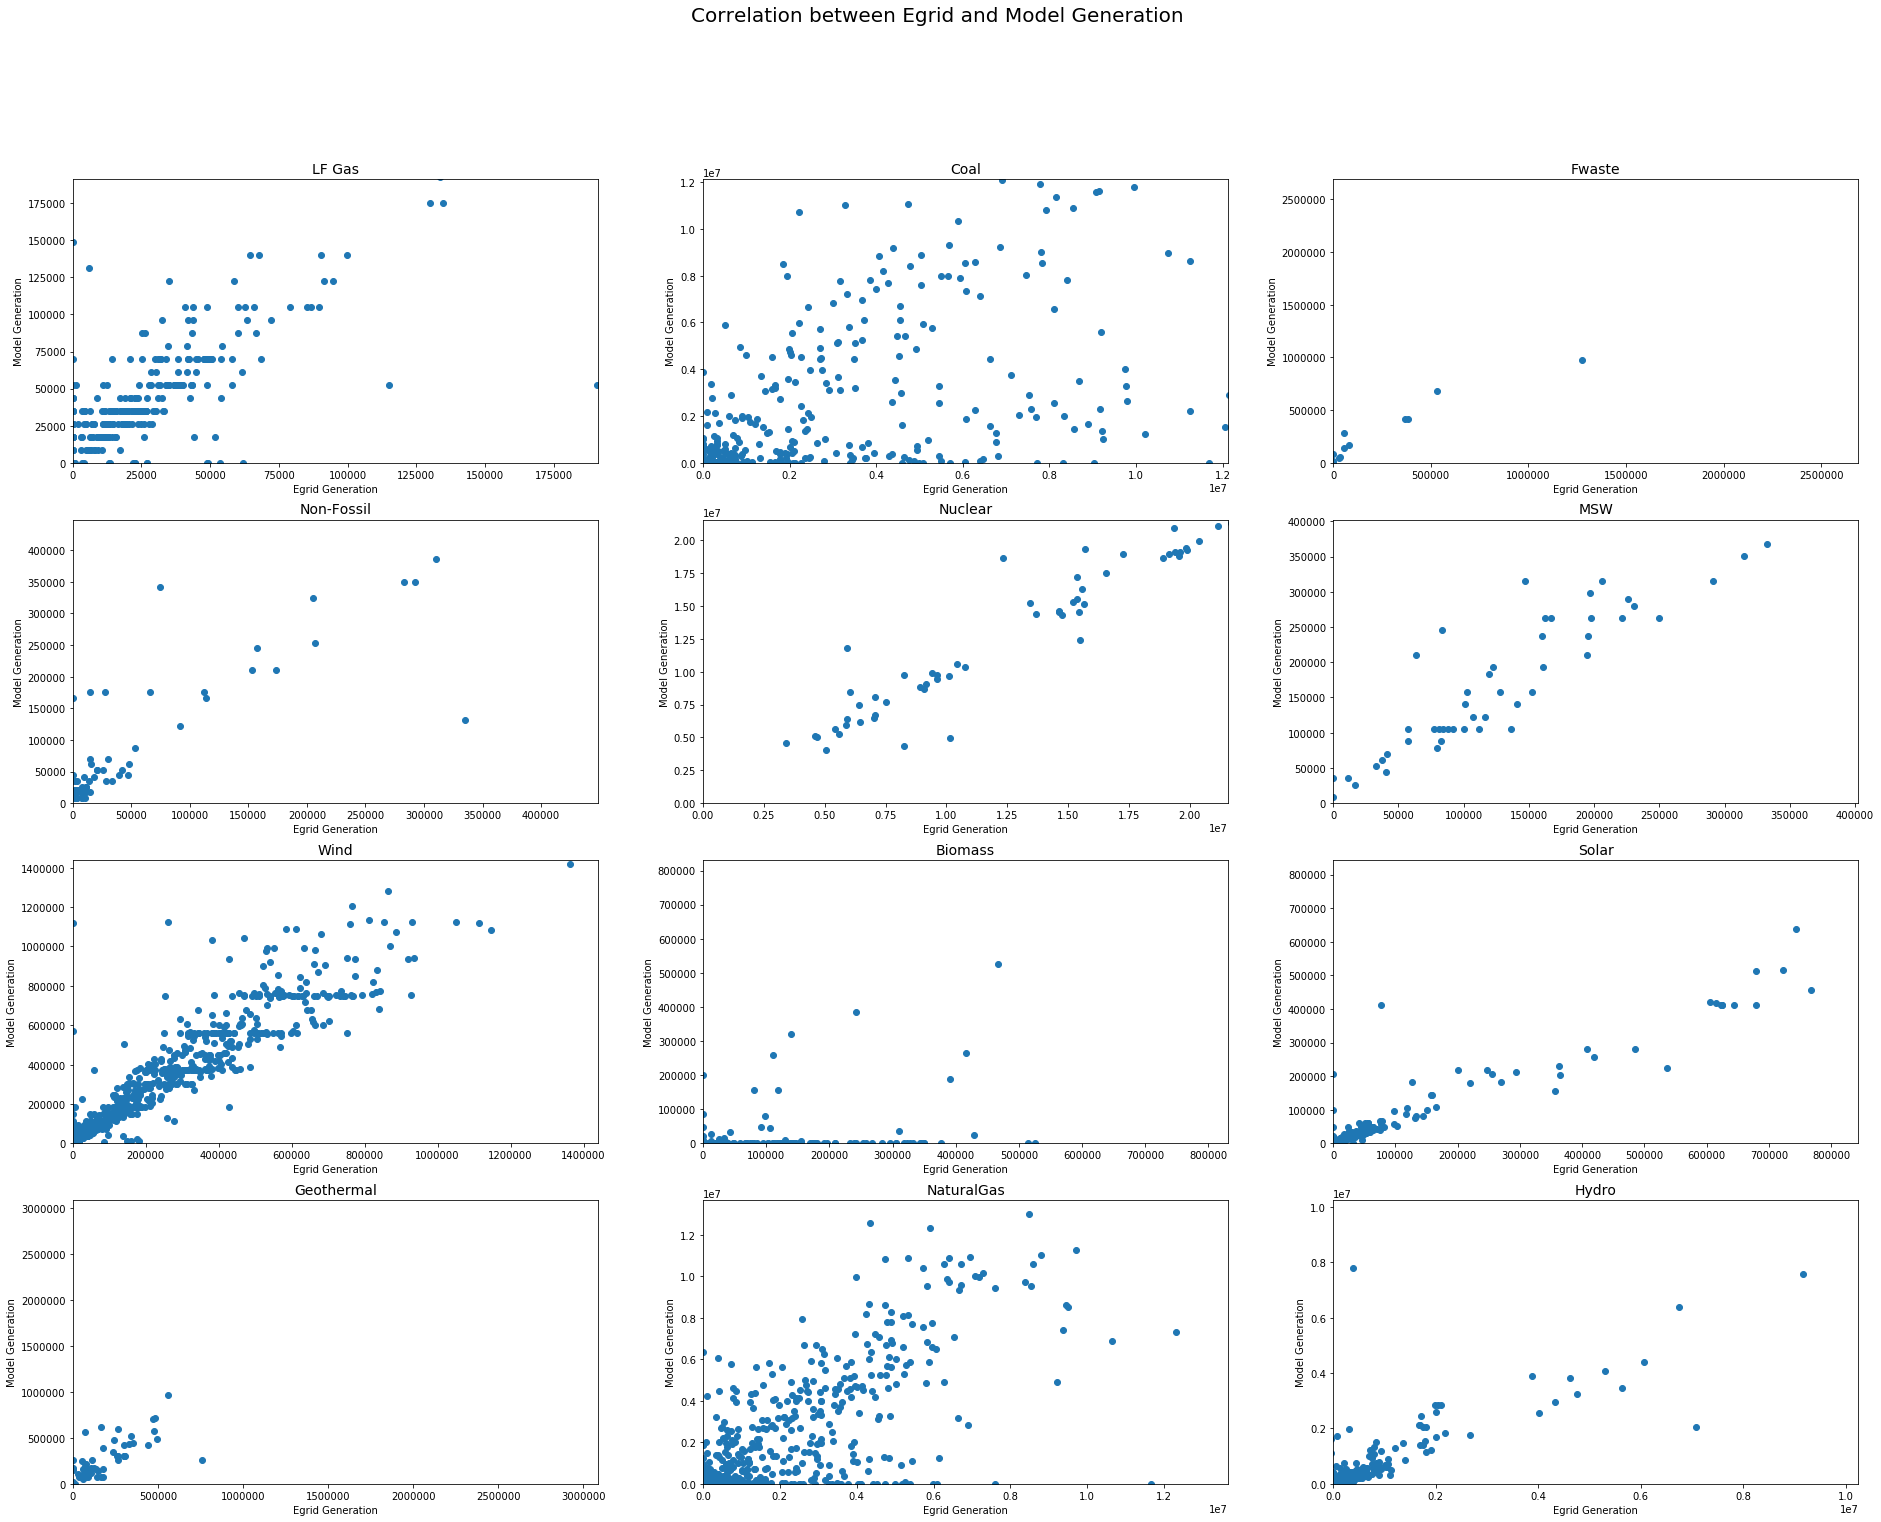

In [74]:
#find the correlation of coal production between 
source_list = ['LF Gas', 'Coal', 'Fwaste','Non-Fossil','Nuclear','MSW','Wind','Biomass','Solar','Geothermal','NaturalGas','Hydro']
fig = plt.figure(figsize = [32,24])
for idx,src in enumerate(source_list):
    #make subplots
    ax = fig.add_subplot(4,3,idx+1)
    #plot a scatterplot
    ax = gmodel_egrid['normal'].sel(ORISCode = (gmodel_egrid['normal']['fueltype'] == src)).plot.scatter(x='egridgeneration', y='annual_modelgeneration')
    #create a max for the x and y lims
    MM = max(gmodel_egrid['normal'].sel(ORISCode = (gmodel_egrid['normal']['fueltype'] == src))['egridgeneration'].max(), gmodel_egrid['normal'].sel(ORISCode = (gmodel_egrid['normal']['fueltype'] == src))['modelgeneration'].max())/1.5
    plt.xlabel('Egrid Generation')
    plt.ylabel('Model Generation')
    plt.xlim([0, MM]);
    plt.ylim([0, MM]);
    plt.title(f'{src}', fontsize = 14)
plt.suptitle('Correlation between Egrid and Model Generation', fontsize = 20);

In [75]:
print('Correlation of our model to egrid generation overall ' + str(gmodel_egrid['normal']['annual_modelgeneration'].to_pandas().corr(gmodel_egrid['normal']['egridgeneration'].to_pandas())))

Correlation of our model to egrid generation overall 0.8419314289857157


## Generation by plant type and region name

In [76]:
def plant_region_plot(ds, xvariable, yvariable1, egrid, yvariable2, figsize, normal = True):
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.3
    plt.bar(ds['nonuc'][xvariable], ds['nonuc'][yvariable1], color = nonuc_color, width = width, align="edge", label = 'No Nuclear')
    if egrid == True:
        plt.bar(ds['normal'][xvariable], ds['normal'][yvariable2], color = egrid_color, width = -width, align="edge", label = 'Egrid')
    if normal == True:
        plt.bar(ds['normal'][xvariable], ds['normal'][yvariable1], color = normal_color, width = width, align="center", label = 'Normal Model')
    plt.xticks(rotation = 45)
    ax.legend();

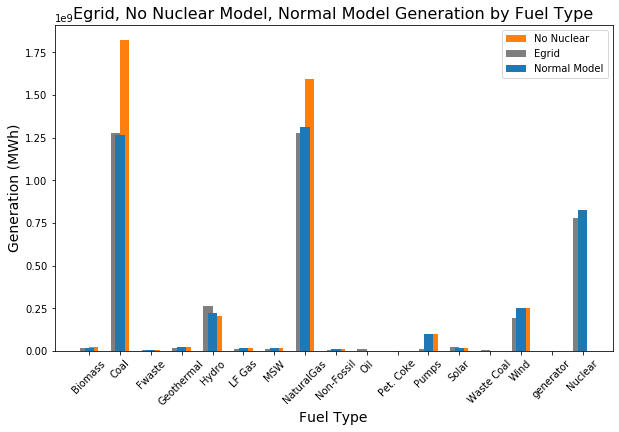

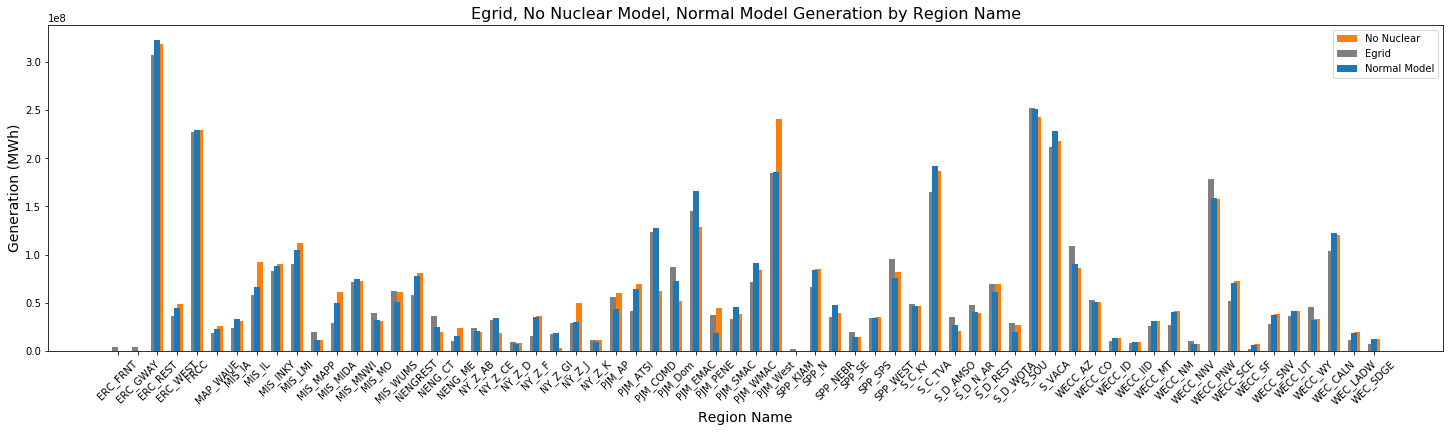

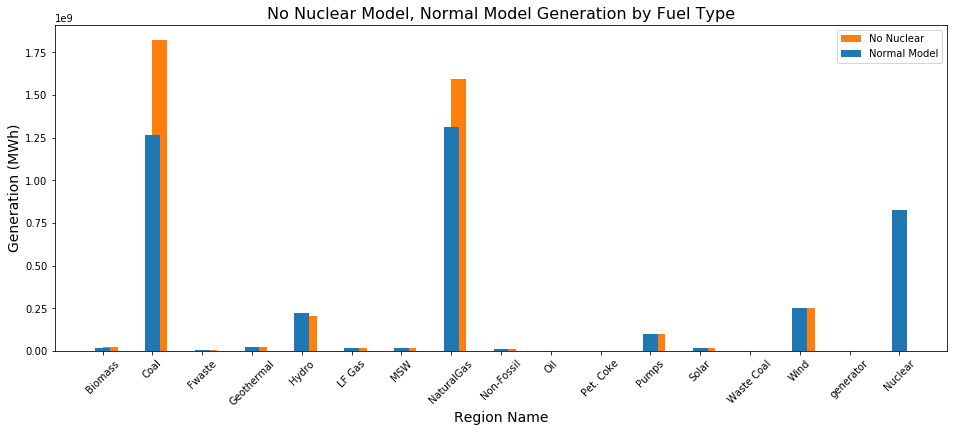

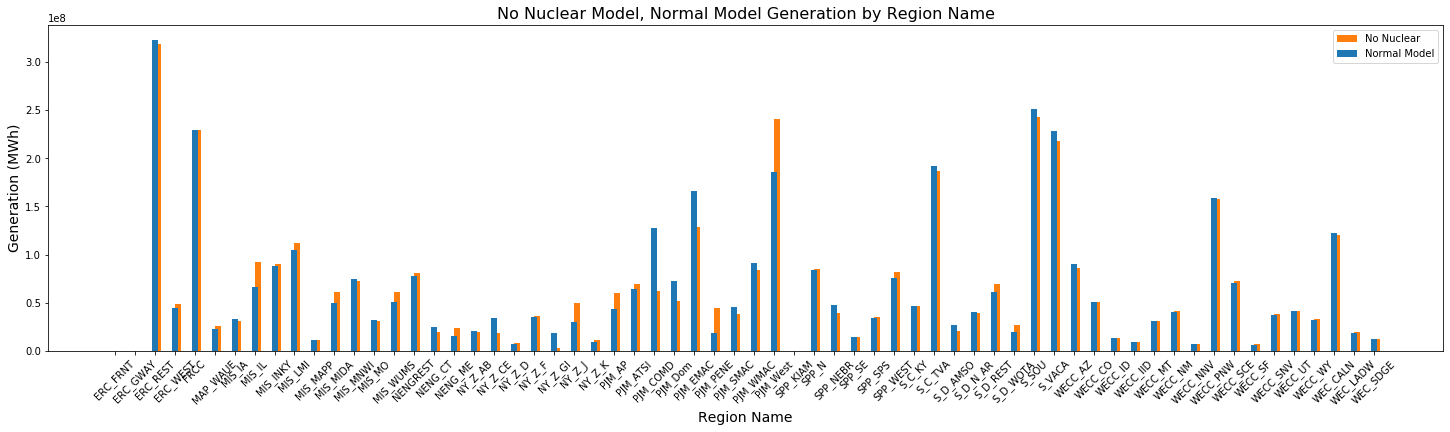

In [77]:
### plot all three egrid, nonuc, normal model generation by:

#fuel type
plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype', yvariable1 = 'annual_modelgeneration',egrid = True, yvariable2 = 'egridgeneration', figsize = [10,6])
plt.xlabel('Fuel Type', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Egrid, No Nuclear Model, Normal Model Generation by Fuel Type', fontsize = 16);
plt.savefig('fuel_type_all.png', dpi=300, bbox_inches = 'tight')

#region name
plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = True, yvariable1 = 'annual_modelgeneration', yvariable2 = 'egridgeneration', figsize = [25,6])
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('Egrid, No Nuclear Model, Normal Model Generation by Region Name', fontsize = 16);
plt.savefig('region_name_all.png', dpi=300, bbox_inches = 'tight')


### plot all model nonuc, normal model generation by:

#fuel type
plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype',egrid = False, yvariable1 = 'annual_modelgeneration', yvariable2 = 'egridgeneration', figsize = [16,6])
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('No Nuclear Model, Normal Model Generation by Fuel Type', fontsize = 16);
plt.savefig('fuel_type_nonuc-normal.png', dpi=300, bbox_inches = 'tight')

#region name
plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = False, yvariable1 = 'annual_modelgeneration', yvariable2 = 'egridgeneration', figsize = [25,6])
plt.xlabel('Region Name', fontsize = 14)
plt.ylabel('Generation (MWh)', fontsize = 14)
plt.title('No Nuclear Model, Normal Model Generation by Region Name', fontsize = 16);
plt.savefig('region_name_nonuc-normal.png', dpi=300, bbox_inches = 'tight')


In [78]:
100*((fueltype_grouped_ds['nonuc']['annual_modelgeneration']-
  fueltype_grouped_ds['normal']['annual_modelgeneration'])/fueltype_grouped_ds['normal']['annual_modelgeneration']).sel(fueltype = 'Coal')

<xarray.DataArray 'annual_modelgeneration' ()>
array(43.67945)
Coordinates:
    fueltype  <U4 'Coal'

## NOx, NO and SO2 Emissions by region and fuel type

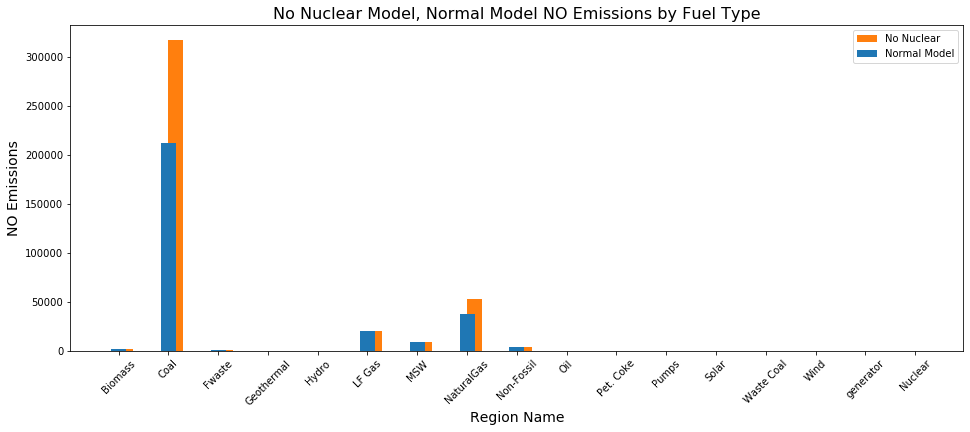

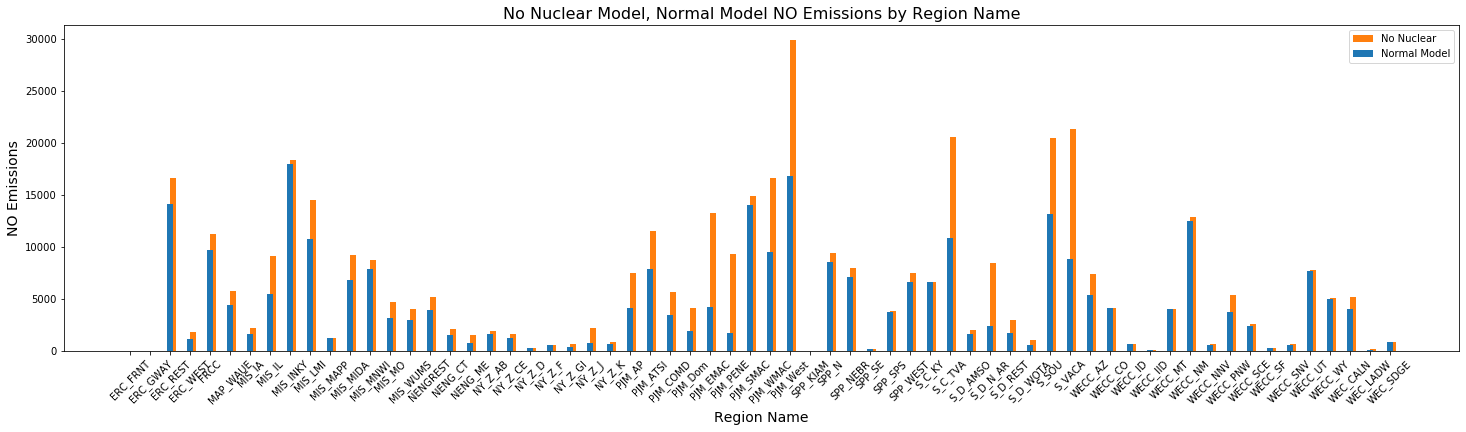

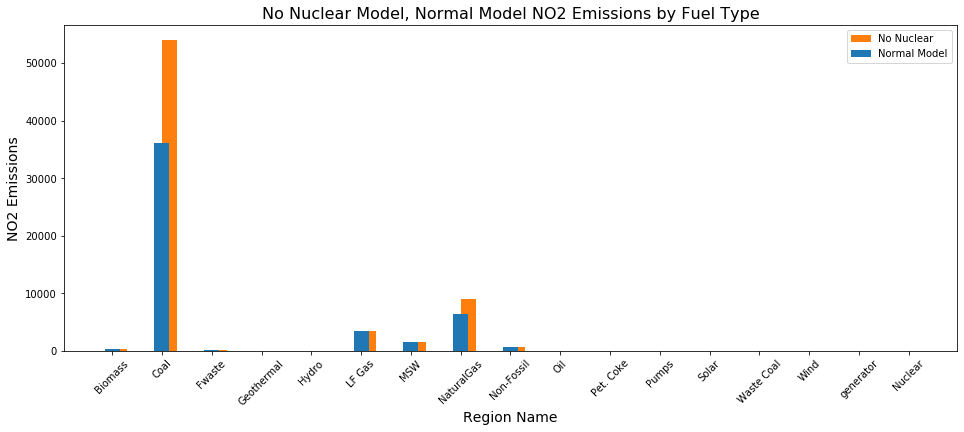

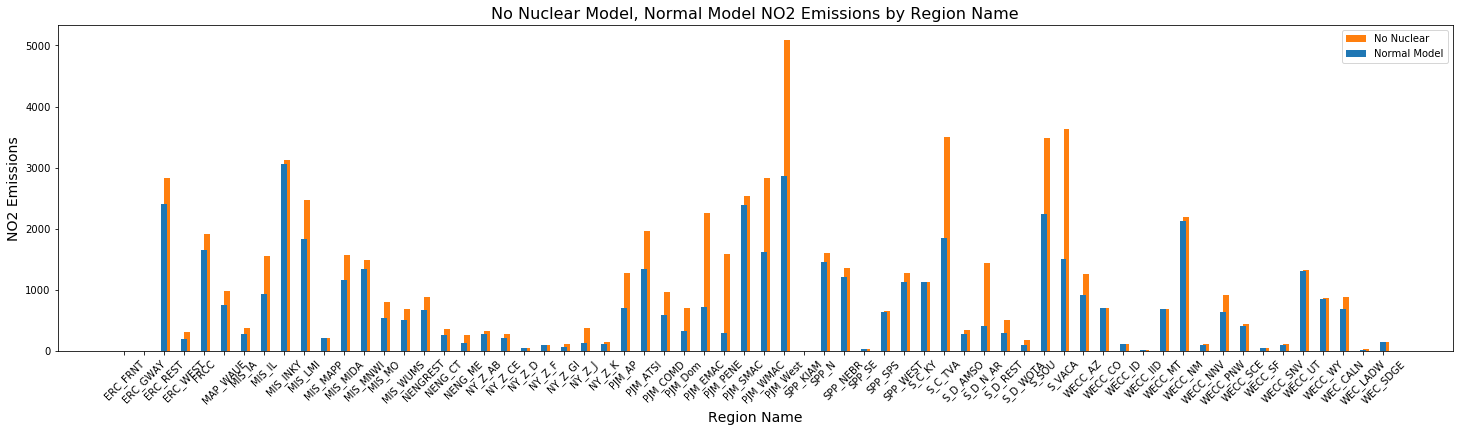

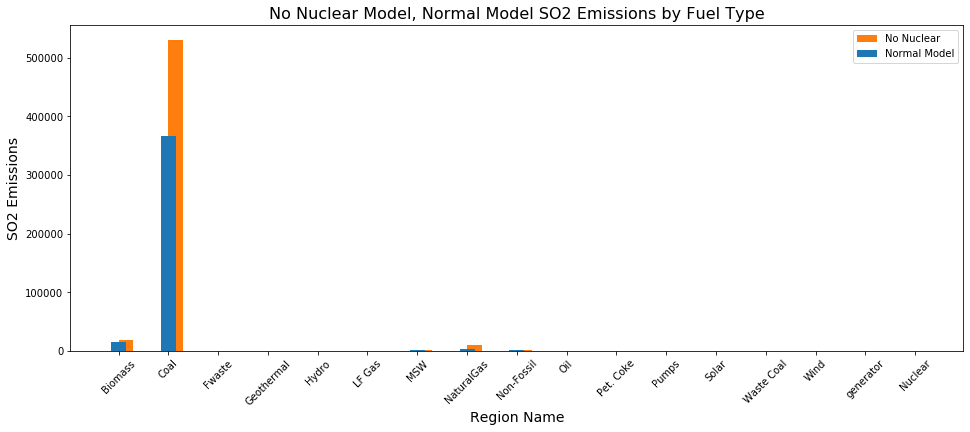

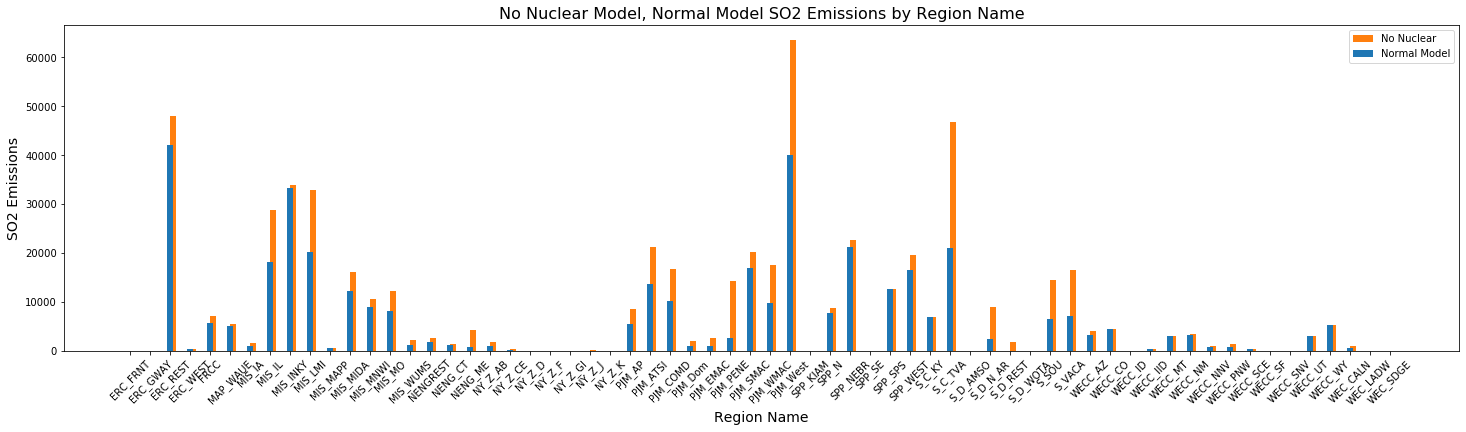

In [79]:
for pollutant in pollutants:
    #plot by fuel type
    plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype',egrid = False, yvariable1 = f'annual_{pollutant}', yvariable2 = 'egridgeneration', figsize = [16,6])
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions', fontsize = 14)
    plt.title(f'No Nuclear Model, Normal Model {pollutant} Emissions by Fuel Type', fontsize = 16);
    #plot by region
    plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = False, yvariable1 = f'annual_{pollutant}', yvariable2 = 'egridgeneration', figsize = [25,6])
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions', fontsize = 14)
    plt.title(f'No Nuclear Model, Normal Model {pollutant} Emissions by Region Name', fontsize = 16);


## Percent Change in Pollutants

In [80]:
### make a percent change variable in pollutants
for pollutant in pollutants:
    fueltype_grouped_ds['nonuc'][f'{pollutant}_percent_change'] = 100* ((fueltype_grouped_ds['nonuc'][f'annual_{pollutant}'] - 
                                 fueltype_grouped_ds['normal'][f'annual_{pollutant}'])/fueltype_grouped_ds['normal'][f'annual_{pollutant}'])

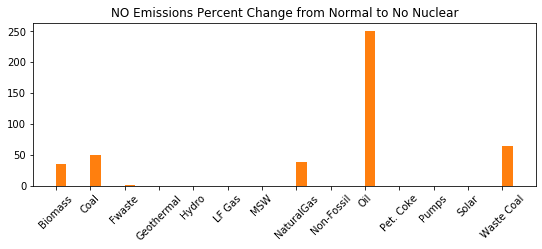

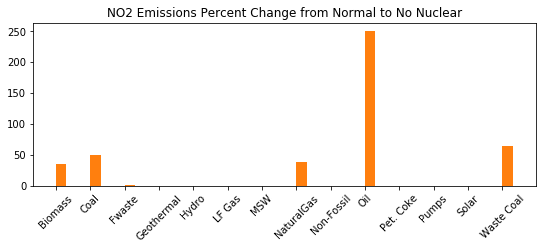

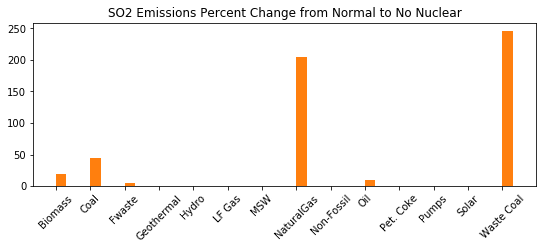

In [81]:
for pollutant in pollutants:
    plant_region_plot(ds = fueltype_grouped_ds, xvariable = 'fueltype', yvariable1 = f'{pollutant}_percent_change',
                      egrid = False, yvariable2 = 'fueltype', figsize = [9,3], normal = False)
    plt.legend().remove()
    plt.title(f'{pollutant} Emissions Percent Change from Normal to No Nuclear')

In [82]:
fueltype_grouped_ds['normal']['annual_SO2'].sel(fueltype = 'Coal')

<xarray.DataArray 'annual_SO2' ()>
array(366088.394859)
Coordinates:
    fueltype  <U4 'Coal'

In [83]:
for pollutant in pollutants:
    print(f'Coal {pollutant} increase ' +
          str(fueltype_grouped_ds['nonuc'][f'{pollutant}_percent_change'].sel(fueltype = 'Coal').values))
    print(f'Natural Gas {pollutant} increase ' +
          str(fueltype_grouped_ds['nonuc'][f'{pollutant}_percent_change'].sel(fueltype = 'NaturalGas').values))

Coal NO increase 49.657068181419035
Natural Gas NO increase 39.592292866109396
Coal NO2 increase 49.657068181418964
Natural Gas NO2 increase 39.59229286610947
Coal SO2 increase 44.693937228444916
Natural Gas SO2 increase 205.46152219771733


## Ratio of Emissions Change to Generation Changes

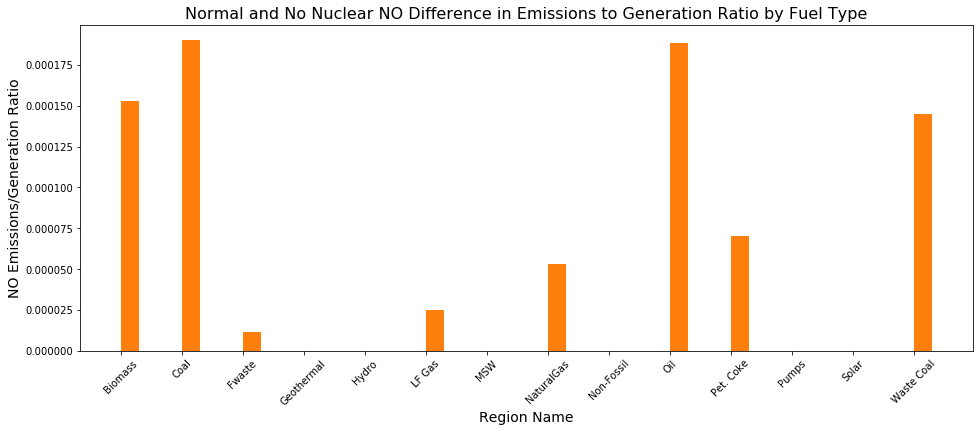

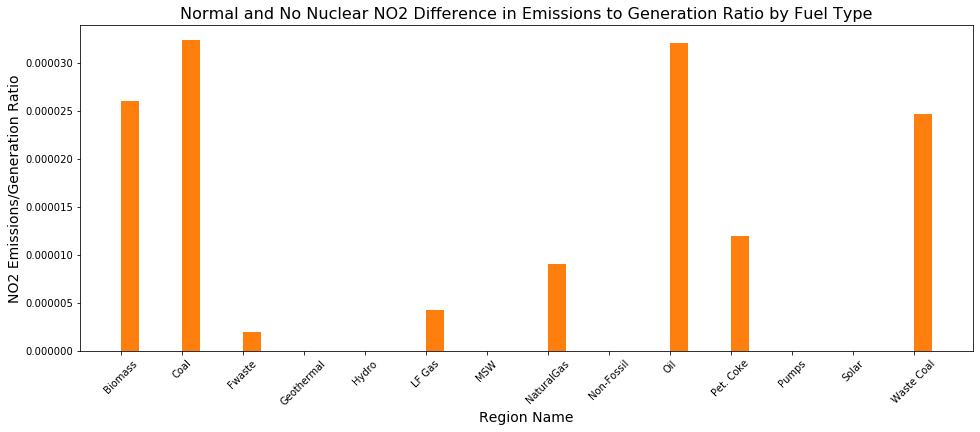

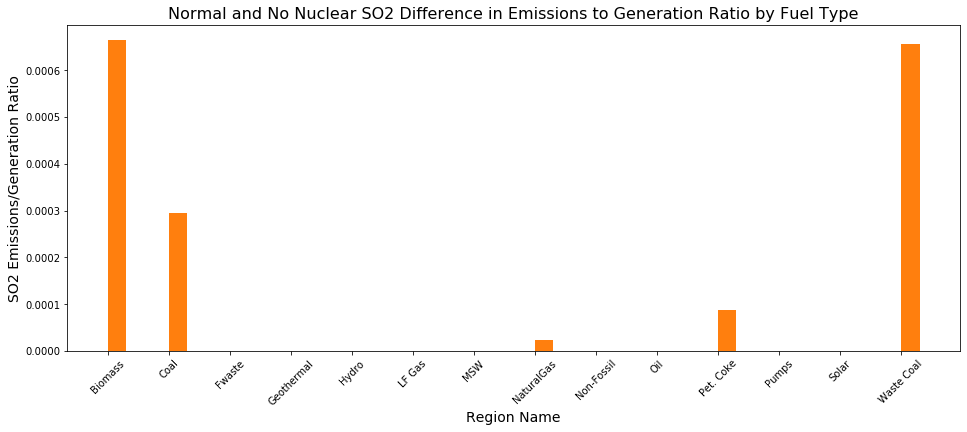

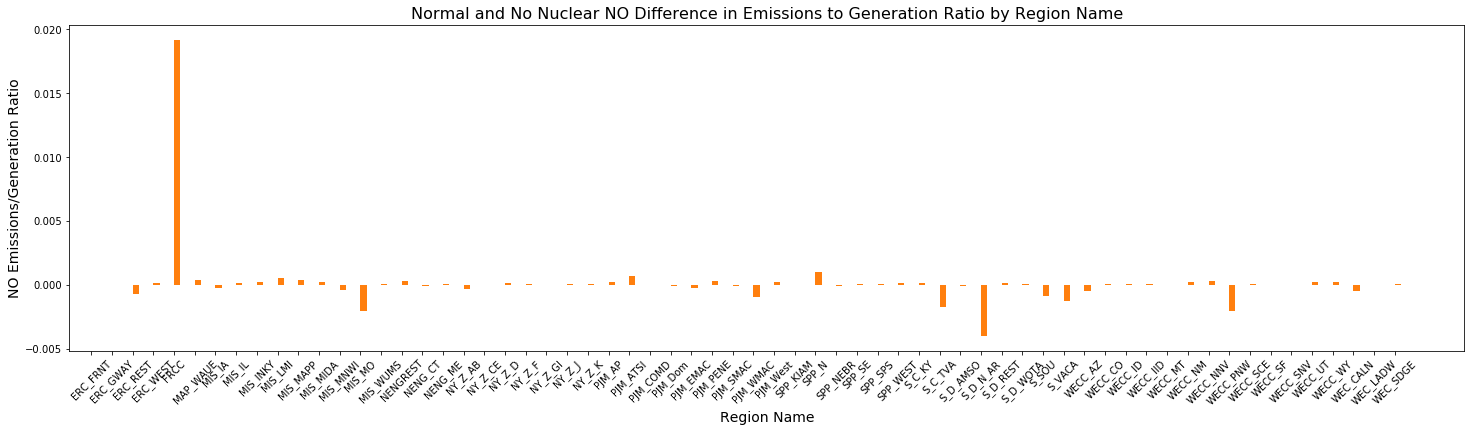

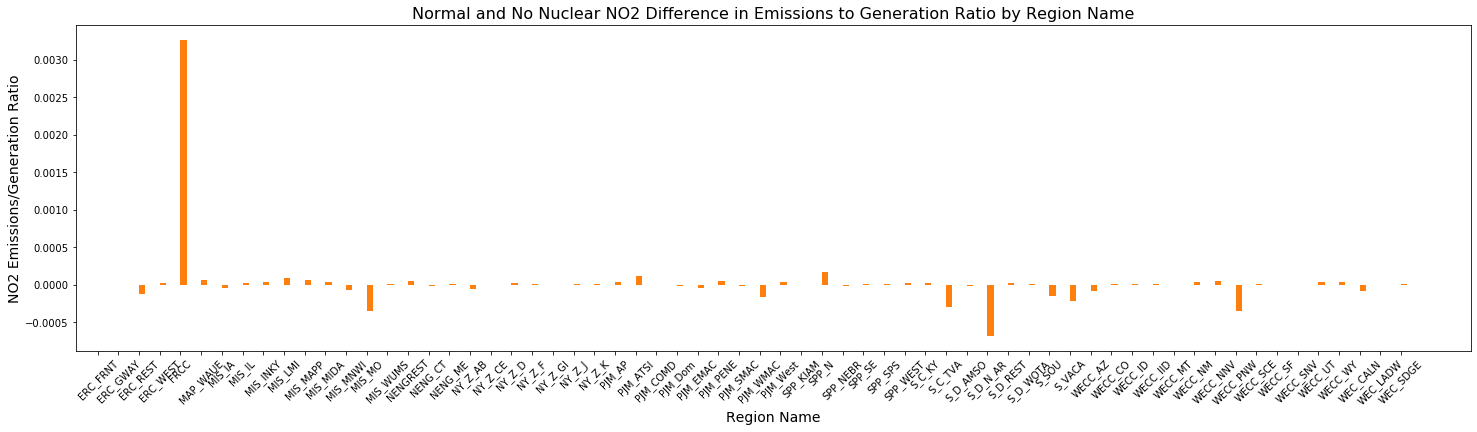

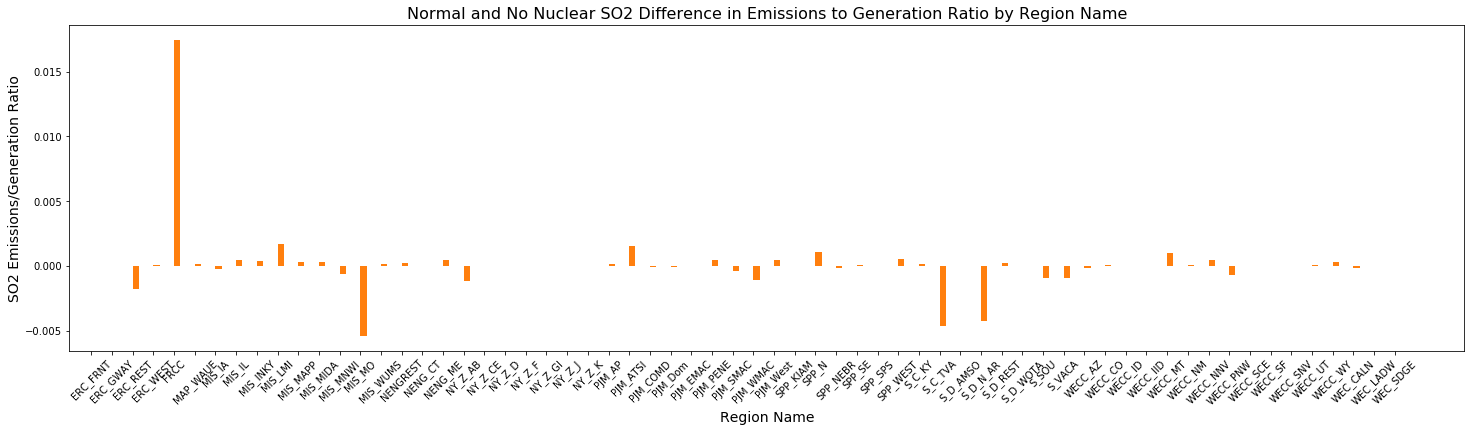

In [84]:
for pollutant in pollutants:
    plant_region_plot(fueltype_grouped_ds, xvariable = 'fueltype',egrid = False, yvariable1 = f'normal-nonuc_{pollutant}-gen_ratio', yvariable2 = 'egridgeneration', figsize = [16,6], normal = False)
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions/Generation Ratio', fontsize = 14)
    plt.legend().remove()
    plt.title(f'Normal and No Nuclear {pollutant} Difference in Emissions to Generation Ratio by Fuel Type', fontsize = 16);

for pollutant in pollutants:
    plant_region_plot(regionname_grouped_ds, xvariable = 'regionname',egrid = False, yvariable1 = f'normal-nonuc_{pollutant}-gen_ratio', yvariable2 = 'egridgeneration', figsize = [25,6], normal = False)
    plt.xlabel('Region Name', fontsize = 14)
    plt.ylabel(f'{pollutant} Emissions/Generation Ratio', fontsize = 14)
    plt.legend().remove()
    plt.title(f'Normal and No Nuclear {pollutant} Difference in Emissions to Generation Ratio by Region Name', fontsize = 16);

# Transmission

In [85]:
trans_df=pd.read_csv('/net/fs11/d0/emfreese/grid_model/outputs/trans.csv')


model_trans=trans_df.sum(axis=1)

#concatenate the model transmission and ORIS files
tmodel_oris_df_raw=pd.concat([model_trans, oris_df],axis=1)
tmodel_oris=tmodel_oris_df_raw.rename(columns={0:'modeltransmission'})

FileNotFoundError: [Errno 2] File b'/net/fs11/d0/emfreese/grid_model/outputs/trans.csv' does not exist: b'/net/fs11/d0/emfreese/grid_model/outputs/trans.csv'